In [2]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import keras

In [9]:

model = load_model("/kaggle/input/llllllll/tensorflow2/default/1/best_model_high_res_512_grayscale (1).h5")
last_conv_layer = "last_conv_layer"
segmentation_model = load_model("/kaggle/input/segmentationtf/tensorflow2/default/1/trained_model.hdf5", compile=False)

""" This function reads a grayscale image from a given path
    resizes it to 512×512, normalizes the pixel values
    and formats it into a 4D array suitable for model input."""
def get_arr_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (512, 512))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1) 
    img = np.expand_dims(img, axis=0)
    return img

""" This function uses a lung segmentation model and OpenCV to generate a
    lung mask from a chest X-ray image by combining outputs from multiple 
    preprocessed versions of the image"""

def mask_lung(img_path, s_model=segmentation_model):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    #Segmentation model
    original = cv2.resize(img, (256, 256))
    original = original.astype("float32") / 255.0
    original = np.expand_dims(original, axis=-1) 
    original = np.expand_dims(original, axis=0)
    git_seg = s_model.predict(original, verbose=0)
    git_seg = np.squeeze(git_seg)

    #openCV
    equalized = cv2.equalizeHist(img)

    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    first = cv2.resize(blurred, (256, 256))
    first = first.astype("float32") / 255.0
    first = np.expand_dims(first, axis=-1) 
    first = np.expand_dims(first, axis=0)
    first_seg = s_model.predict(first, verbose=0)
    first_seg = np.squeeze(first_seg) 

    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)

    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    second = cv2.resize(opened, (256, 256))
    second = second.astype("float32") / 255.0
    second = np.expand_dims(second, axis=-1) 
    second = np.expand_dims(second, axis=0)
    second_seg = s_model.predict(second, verbose=0)
    second_seg = np.squeeze(second_seg)

    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lung_mask = np.zeros_like(img)
    cv2.drawContours(lung_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    segmented = cv2.bitwise_and(img, img, mask=lung_mask)
    third = cv2.resize(segmented, (256, 256))
    third = third.astype("float32") / 255.0
    third = np.expand_dims(third, axis=-1) 
    third = np.expand_dims(third, axis=0)
    third_seg = s_model.predict(third, verbose=0)
    third_seg = np.squeeze(third_seg)

    mask = np.maximum.reduce([git_seg, first_seg, second_seg, third_seg])
    mask = np.expand_dims(mask, axis=-1) 
    mask = tf.image.resize(mask, [512, 512], method='bilinear')
    return mask
    
"""This function generates a Grad-CAM heatmap for a given image and model """
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = tf.image.resize(
        heatmap[..., tf.newaxis],  
        (512, 512),
        method=tf.image.ResizeMethod.BILINEAR  
    )
    return heatmap.numpy()


""" This function computes a Grad-CAM heatmap for an image
    multiplies it with a lung mask to focus only on lung regions
    and returns the masked heatmap highlighting the most relevant lung areas"""
def meaningful(img_path):
    img_arr = get_arr_img(img_path)
    mask = mask_lung(img_path)
    img_array = get_arr_img(img_path)
    grad_cam = make_gradcam_heatmap(img_array, model, last_conv_layer)
    masked_heatmap = grad_cam * mask
    return masked_heatmap.numpy()

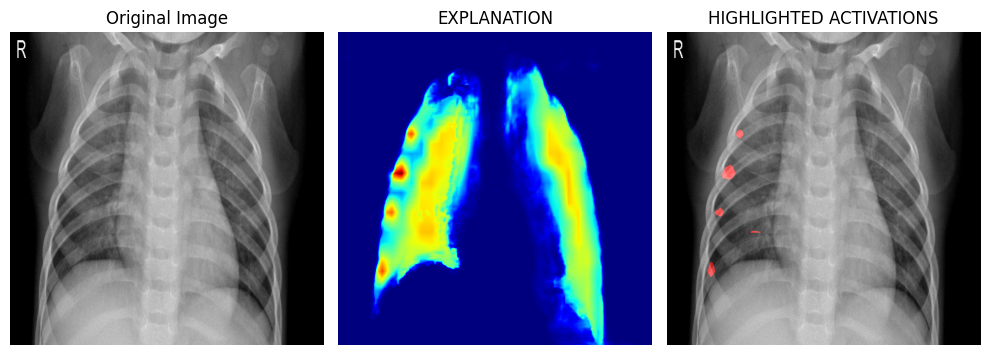

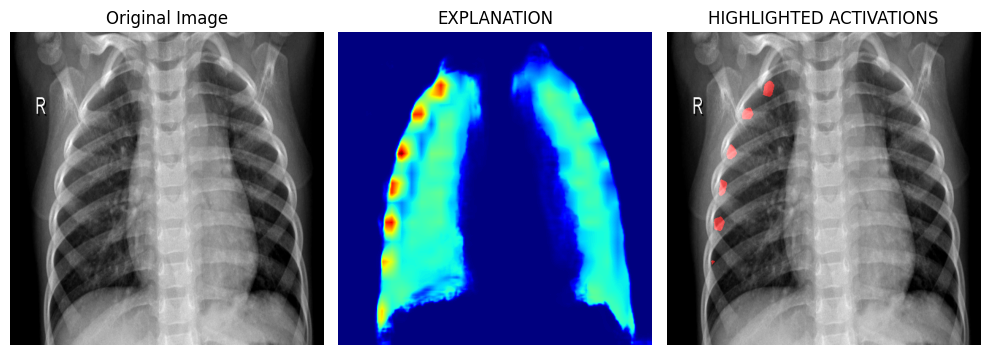

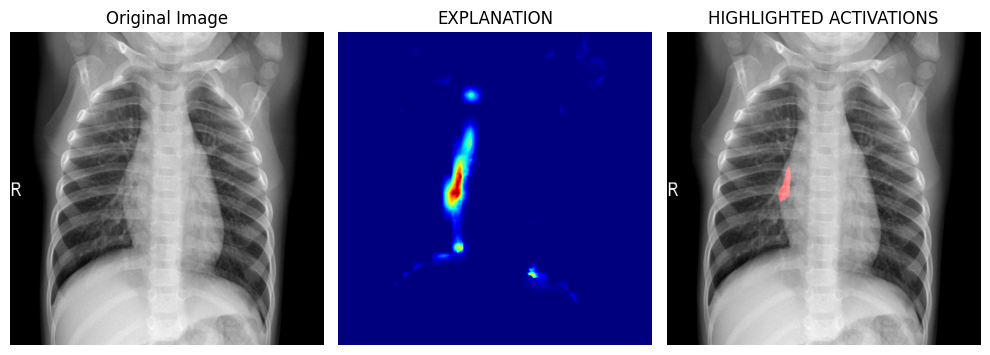

In [13]:
#NORMAL XRAY
folder = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL"
files = os.listdir(folder)
for img in files[:3]:
    img_path = os.path.join(folder, img)
    heatmap = meaningful(img_path)
    
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (512, 512))
    alpha = 0.4
    image = np.float32(image)
    
    heatmap = cv2.resize(heatmap, (512, 512))
    
    heatmap = np.nan_to_num(heatmap)
    
    superimposed_img = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0)
    
    heatmap_min = np.min(heatmap)
    heatmap_max = np.max(heatmap)
    if heatmap_max > heatmap_min: 
        heatmap_norm = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)
    else:
        heatmap_norm = np.zeros_like(heatmap)
    
    threshold_value = 0.7
    mask = heatmap_norm > threshold_value
    
    highlight_mask = np.zeros((512, 512, 3), dtype=np.uint8)
    highlight_mask[mask, 0] = 255 
    
    image_rgb = cv2.cvtColor(np.uint8(image), cv2.COLOR_GRAY2RGB)
    highlighted_img = cv2.addWeighted(image_rgb, 1.0, highlight_mask, 0.6, 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 7))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title("EXPLANATION")
    axes[1].axis('off')
    
    axes[2].imshow(highlighted_img)
    axes[2].set_title("HIGHLIGHTED ACTIVATIONS")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

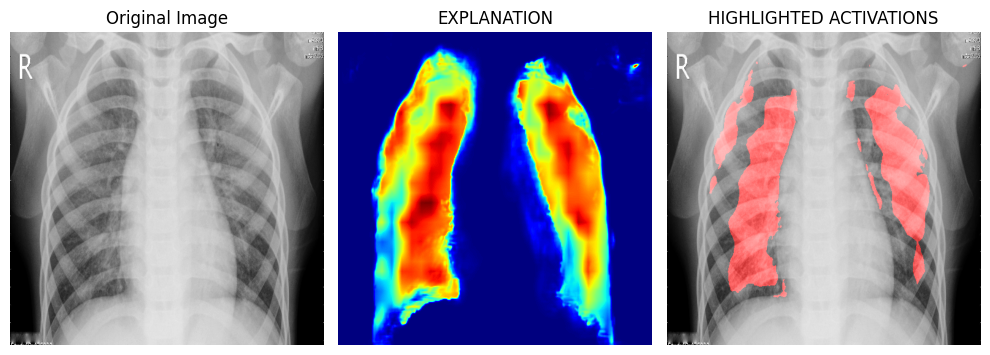

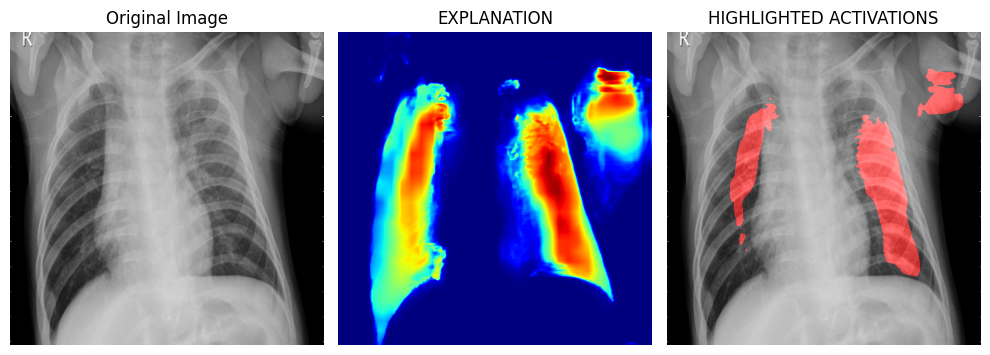

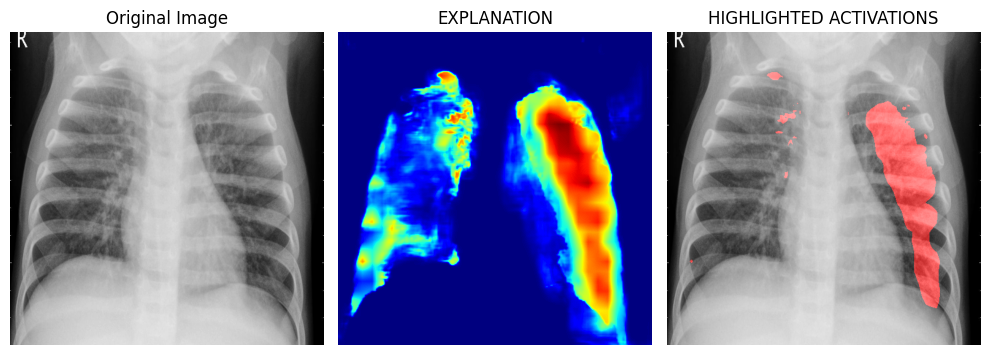

In [16]:
#PNEUMONIA XRAY
folder = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA"
files = os.listdir(folder)
for img in files[:3]:
    img_path = os.path.join(folder, img)
    heatmap = meaningful(img_path)
    
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (512, 512))
    alpha = 0.4
    image = np.float32(image)
    
    heatmap = cv2.resize(heatmap, (512, 512))
    
    heatmap = np.nan_to_num(heatmap)
    
    superimposed_img = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0)
    
    heatmap_min = np.min(heatmap)
    heatmap_max = np.max(heatmap)
    if heatmap_max > heatmap_min: 
        heatmap_norm = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)
    else:
        heatmap_norm = np.zeros_like(heatmap)
    
    threshold_value = 0.7
    mask = heatmap_norm > threshold_value
    
    highlight_mask = np.zeros((512, 512, 3), dtype=np.uint8)
    highlight_mask[mask, 0] = 255 
    
    image_rgb = cv2.cvtColor(np.uint8(image), cv2.COLOR_GRAY2RGB)
    highlighted_img = cv2.addWeighted(image_rgb, 1.0, highlight_mask, 0.6, 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 7))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title("EXPLANATION")
    axes[1].axis('off')
    
    axes[2].imshow(highlighted_img)
    axes[2].set_title("HIGHLIGHTED ACTIVATIONS")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()